In [1]:
!pip install yfinance
!pip install torchsummaryX
!pip install wandb -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 742 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 17.5 MB/s 
     |████████████████████████████████| 168 kB 73.0 MB/s 
     |████████████████████████████████| 182 kB 73.4 MB/s 
     |████████████████████████████████| 62 kB 1.3 MB/s 
     |████████████████████████████████| 140 kB 77.0 MB/s 


In [77]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import yfinance as yf
import pandas as pd
import datetime
import torch
import torch.nn as nn
from torchsummaryX import summary
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc
import seaborn as sn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.getcwd()

Mounted at /content/drive


'/content'

In [4]:
import wandb
wandb.login(key="03916b709446813b51f72a1b29a2854a9dd9e3f7")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Training Config
config = {
    "batch_size" : 32,
    "lr" : 1e-3,
    "epochs" : 100,
    "look_back" : 60,
    "feature_dim" : 6,
    "hidden_dim" : 64,
    "output_dim" : 1,
    "num_layers" : 3,
    "dropout" : 0.5
}

In [7]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 200)

class VolatiltiyData:

    def __init__(self, tickers, start_year, start_month, start_date, end_year,
                 end_month, end_date, freq, scaling_factor, windows, y_window):
        self.tickers = tickers
        self.start = datetime.datetime(start_year, start_month, start_date)
        self.end = datetime.datetime(end_year, end_month, end_date)
        self.freq = freq
        self.scaling_factor = scaling_factor
        # 过去几天的vol
        self.windows = windows
        # Predict几天的vol
        self.y_window = y_window 

    def get_data(self):
        """
        Output:
        raw data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 
                     'Log Adj Close', 'Log Return', 'Log Volume', 'Log Volume Chg', 'Log Range', '10-day-vol']
        """
        data = yf.download(self.tickers, start = self.start, end = self.end, interval = self.freq)
        data["Log Adj Close"] = np.log(data["Adj Close"])
        data["Log Return"] = np.insert(np.diff(data["Log Adj Close"]), 0, 0) * self.scaling_factor
        data["Log Volume"] = np.log(data["Volume"])
        data["Log Volume Chg"] = np.insert(np.diff(data["Log Volume"]), 0, 0)
        data["Log Range"] = np.log(data["High"] / data["Low"]) * self.scaling_factor
        data["10-day-vol"] = data["Log Return"].rolling(10).std(ddof=0)
        data["30-day-vol"] = data["Log Return"].rolling(30).std(ddof=0)

        return data

    def get_vix_data(self):
        """
        Output:
        raw vix data -> ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        """
        data = yf.download("^VIX", start = self.start, end = self.end, interval = self.freq)
        
        return data

    def prepare_data(self, *args):
        """
        Prepare data for training. Select features that are needed. Perform necessary normalization.
        
        For volatiltiy data, we need to remove initial n days since we need at least n days to calculate volatiltiy.

        Input:
        Multiple types of data:
        Basic data: 10-day-vol, Log Volume Chg, Log Range
        Optional data: VIX?

        Output:
        dataset ->  (samples, features)
        scalar  ->  scalar for our normalization

        Current features:
        [10-day-vol, Log Return, Log Volume Chg, Log Range, 30-day-vol, VIX]
        Update based on correlation [10-day-vol, Log Range, 30-day-vol, VIX]
        """
        data = args[0]
        vol_10 = data['10-day-vol'].values.reshape(-1, 1)
        log_return = data['Log Return'].values.reshape(-1, 1)
        log_vlmchg = data['Log Volume Chg'].values.reshape(-1, 1)
        log_range = data['Log Range'].values.reshape(-1, 1)
        vol_30 = data['30-day-vol'].values.reshape(-1, 1)
        
        dataset = vol_10
        dataset = np.append(dataset, log_return, axis=1)
        dataset = np.append(dataset, log_vlmchg, axis = 1)
        dataset = np.append(dataset, log_range, axis = 1)
        dataset = np.append(dataset, vol_30, axis = 1)
        
        # For appending more types of data -> VIX
        for i in range(1, len(args)):
            extra_data = args[i]['Adj Close'].values.reshape(-1, 1)
            dataset = np.append(dataset, extra_data, axis = 1)

        dataset = dataset[31:]
        
        # normalize the dataset
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(dataset)
        return dataset, vol_10, scaler

volatiltiy_data = VolatiltiyData(
                      "^GSPC",
                      1990, 1, 2,
                      2022, 12, 12,
                      freq="1d",
                      scaling_factor=100,
                      windows=[10], # 过去几天的vol
                      y_window=10 # Predict几天的vol
                  )

data = volatiltiy_data.get_data()
# print(np.shape(data))
# print(data)
# print("#######################################################################")
vix_data = volatiltiy_data.get_vix_data()
# print(np.shape(vix_data))
# print(vix_data)
# print("#######################################################################")
dataset, vol_10, scaler = volatiltiy_data.prepare_data(data, vix_data)
print(np.shape(dataset))
# print(dataset)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(8270, 6)


            10-day-vol  Log Return  Log Volume Chg  Log Range  30-day-vol        VIX  Future 10-day-vol
Date                                                                                                   
1990-01-02         NaN    0.000000        0.000000   2.166817         NaN  17.240000                NaN
1990-01-03         NaN   -0.258889        0.171184   0.751585         NaN  18.190001                NaN
1990-01-04         NaN   -0.865030       -0.083063   1.649723         NaN  19.219999                NaN
1990-01-05         NaN   -0.980414       -0.110206   1.222048         NaN  20.110001                NaN
1990-01-08         NaN    0.450431       -0.123516   1.049977         NaN  20.260000                NaN
...                ...         ...             ...        ...         ...        ...                ...
2022-12-05    1.314086   -1.805625        0.064700   1.691230    1.582112  20.750000           1.388753
2022-12-06    1.388753   -1.450387        0.020248   2.099096   

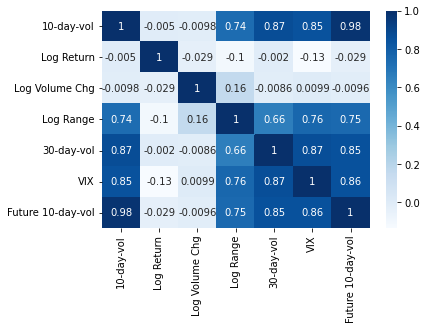

In [82]:
df = data.copy()
df['VIX'] = vix_data['Adj Close']
df['Future 10-day-vol'] = list(df['10-day-vol'])[1:] + [0]
df = df[['10-day-vol', 'Log Return', 'Log Volume Chg', 'Log Range', '30-day-vol', 'VIX', 'Future 10-day-vol']]
corr_mtx = df.iloc[31:, :].corr()

print(df)

df = pd.DataFrame(corr_mtx, columns = ['10-day-vol','Log Return','Log Volume Chg', 'Log Range', '30-day-vol', 'VIX', 'Future 10-day-vol'], \
                          index = ['10-day-vol','Log Return','Log Volume Chg', 'Log Range', '30-day-vol', 'VIX', 'Future 10-day-vol'])

hm = sn.heatmap(data = df, cmap="Blues", annot=True)

In [9]:
class DataLoaderForVolatilityModeling(DataLoader):
    """
    Construct dataloader
  
    The label for our data is the next 10-day volatility after our input.

    Output:
    input -> (batch_size, seq_len, feature_size)
    label -> (batch_size, 1, feature_size) 
    """
    def __init__(self, dataset, vol_10, batch_size, sequence_length, shuffle=True, feature_size=1):
        self.dataset = dataset
        self.vol_10 = vol_10
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequence_length = sequence_length
        self.num_batches = (np.shape(self.dataset)[0]-10) // self.batch_size
        self.feature_size = feature_size

    def __len__(self):
        return self.num_batches - self.sequence_length

    def __iter__(self):
        # group the sequence into batches
        x = torch.from_numpy(np.reshape(self.dataset[:self.num_batches*self.batch_size, :], (self.batch_size, self.num_batches, config['feature_dim']))).type(torch.float32)
        y = torch.from_numpy(np.reshape(self.vol_10[10:self.num_batches*self.batch_size+10, :], (self.batch_size, -1))).type(torch.float32)

        # return a tuple of (input, label) on every iteration with yield
        index = 0
        while index+self.sequence_length < self.num_batches:
            time_steps = self.sequence_length
            input = x[:, index:index+time_steps, :]
            label = y[:, index+time_steps].view(self.batch_size, 1)
            index += 1
            yield input, label

In [10]:
# sanity check
dataloader = DataLoaderForVolatilityModeling(dataset, vol_10, batch_size=config["batch_size"], sequence_length=config["look_back"], feature_size=config["feature_dim"])
tmp = iter(dataloader)
input, label = next(tmp) 
print(f'input shape = {np.shape(input)}')
print(f'label shape = {np.shape(label)}')

input shape = torch.Size([32, 60, 6])
label shape = torch.Size([32, 1])


In [96]:
# model
class Model(nn.Module):
    """
    Construct model architecture
    """
    def __init__(self, feature_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.lstm = torch.nn.GRU(input_size=feature_dim, hidden_size=hidden_dim, num_layers=config["num_layers"], 
                                  dropout=config["dropout"], batch_first=True, bias=True, bidirectional=True)
        self.relu = torch.nn.ReLU()
        self.linear = torch.nn.Linear(in_features=hidden_dim*2, out_features=output_dim, bias=True)

    def forward(self, x):
        x, h = self.lstm(x)
        x = x[:, -1, :]
        x = self.relu(x)
        x = self.linear(x)
        return x

In [97]:
# sanity check
torch.cuda.empty_cache()

model = Model(config['feature_dim'], config['hidden_dim'], config['output_dim']).to(device)
prediction = model(input.to(device))
print(f'shape of prediction : {prediction.shape}')
print(f'shape of label : {label.shape}')

summary(model, input.to(device))

shape of prediction : torch.Size([32, 1])
shape of label : torch.Size([32, 1])
         Kernel Shape   Output Shape   Params Mult-Adds
Layer                                                  
0_lstm              -  [32, 60, 128]  176.64k  174.336k
1_relu              -      [32, 128]        -         -
2_linear     [128, 1]        [32, 1]    129.0     128.0
---------------------------------------------------------
                        Totals
Total params          176.769k
Trainable params      176.769k
Non-trainable params       0.0
Mult-Adds             174.464k


/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_lstm,-,"[32, 60, 128]",176640.0,174336.0
1_relu,-,"[32, 128]",NaN,NaN
2_linear,"[128, 1]","[32, 1]",129.0,128.0


In [98]:
# Prepare loader
train_size = int(len(dataset) * 0.5)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = dataset[0:train_size,:], dataset[train_size:train_size+val_size,:], dataset[train_size+val_size:len(dataset),:]
train_vol_10, val_vol_10, test_vol_10 = vol_10[0:train_size,:], vol_10[train_size:train_size+val_size,:], vol_10[train_size+val_size:len(dataset),:]

train_loader = DataLoaderForVolatilityModeling(train_data, train_vol_10, batch_size=config['batch_size'], sequence_length=config['look_back'], shuffle=True)
val_loader = DataLoaderForVolatilityModeling(val_data, val_vol_10, batch_size=10, sequence_length=config['look_back'], shuffle=False)
test_loader = DataLoaderForVolatilityModeling(test_data, test_vol_10, batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Prepare optimizer, criterion, and scheduler_lr
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay = 5e-5) # What goes in here?
criterion = torch.nn.MSELoss()
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.75, patience=2, verbose=True)

In [99]:
# Evaluate
def evaluate(val_loader, model, criterion):
    model.eval()

    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    val_loss = 0

    for i, (input, target) in enumerate(val_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        loss = criterion(prediction.flatten(), target.flatten())

        val_loss += loss.item()
        # print(loss.item())

        batch_bar.set_postfix(
            loss = f"{val_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target

    batch_bar.close()
    val_loss /= len(dataloader)

    return val_loss

In [100]:
# Train Step
def train_step(train_loader, model, optimizer, criterion):
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    train_loss = 0
    model.train()

    for i, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        curr_lr = optimizer.param_groups[0]['lr']

        optimizer.zero_grad()
        prediction = model(input)
        # print(f'prediction : {prediction}')
        # print(f'target : {target}')
        loss = criterion(prediction.flatten(), target.flatten())
        # print(f'loss : {loss.item()}')

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        batch_bar.set_postfix(
            loss = f"{train_loss/ (i+1):.4f}",
            lr = f"{curr_lr}"
        )

        batch_bar.update()

        torch.cuda.empty_cache()
        del input
        del target
    
    batch_bar.close()
    train_loss /= len(train_loader)
    
    return train_loss

In [101]:
# Initialize wandb
run = wandb.init(
    name = "LSTM_mult_feats_6", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "10701_Volatility_Prediction", ### Project should be created in your wandb account 
    config = config ### Wandb Config for your run
)

In [102]:
best_val_loss = 100

# Train loop
torch.cuda.empty_cache()
gc.collect()

train_loss, val_loss = 0, 0

for epoch in range(config["epochs"]):
    
    curr_lr = optimizer.param_groups[0]['lr']

    train_loss = train_step(train_loader, model, optimizer, criterion)

    val_loss = evaluate(val_loader, model, criterion)

    scheduler_lr.step(train_loss)

    print("\nEpoch {}/{}: \n\t Train Loss {:.07f}\t Eval Loss {:.07f}\t Learning Rate {:.04f}\t".format(
          epoch + 1,
          config['epochs'],
          train_loss,
          val_loss,
          curr_lr))
    
    wandb.log({"train_loss":train_loss, 'val_loss': val_loss, "learning_Rate": curr_lr})

    if val_loss < best_val_loss:
        path = '/content/drive/MyDrive/10701/checkpoint/checkpoint_eval_loss_haha'.format(val_loss)
        torch.save({'model_state_dict': model.state_dict()}, path)
        best_val_loss = val_loss

wandb.save(path)
run.finish()


Epoch 1/100: 
	 Train Loss 0.1880536	 Eval Loss 0.3647210	 Learning Rate 0.0010	



Epoch 2/100: 
	 Train Loss 0.0628991	 Eval Loss 0.2025717	 Learning Rate 0.0010	



Epoch 3/100: 
	 Train Loss 0.0492489	 Eval Loss 0.1480303	 Learning Rate 0.0010	



Epoch 4/100: 
	 Train Loss 0.0445326	 Eval Loss 0.1197788	 Learning Rate 0.0010	



Epoch 5/100: 
	 Train Loss 0.0390267	 Eval Loss 0.0963282	 Learning Rate 0.0010	



Epoch 6/100: 
	 Train Loss 0.0339155	 Eval Loss 0.0967442	 Learning Rate 0.0010	



Epoch 7/100: 
	 Train Loss 0.0309477	 Eval Loss 0.1059050	 Learning Rate 0.0010	



Epoch 8/100: 
	 Train Loss 0.0304983	 Eval Loss 0.0930690	 Learning Rate 0.0010	



Epoch 9/100: 
	 Train Loss 0.0281435	 Eval Loss 0.0967594	 Learning Rate 0.0010	



Epoch 10/100: 
	 Train Loss 0.0282296	 Eval Loss 0.0890593	 Learning Rate 0.0010	



Epoch 11/100: 
	 Train Loss 0.0251460	 Eval Loss 0.0716138	 Learning Rate 0.0010	



Epoch 12/100: 
	 Train Loss 0.0206464	 Eval Loss 0.0653344	 Learning Rate 0.0010	



Epoch 13/100: 
	 Train Loss 0.0205475	 Eval Loss 0.0740946	 Learning Rate 0.0010	



Epoch 14/100: 
	 Train Loss 0.0193528	 Eval Loss 0.0707973	 Learning Rate 0.0010	



Epoch 15/100: 
	 Train Loss 0.0189595	 Eval Loss 0.0615338	 Learning Rate 0.0010	



Epoch 16/100: 
	 Train Loss 0.0179122	 Eval Loss 0.0655259	 Learning Rate 0.0010	



Epoch 17/100: 
	 Train Loss 0.0165250	 Eval Loss 0.0554831	 Learning Rate 0.0010	



Epoch 18/100: 
	 Train Loss 0.0142553	 Eval Loss 0.0491778	 Learning Rate 0.0010	



Epoch 19/100: 
	 Train Loss 0.0136330	 Eval Loss 0.0602146	 Learning Rate 0.0010	



Epoch 20/100: 
	 Train Loss 0.0133887	 Eval Loss 0.0543458	 Learning Rate 0.0010	



Epoch 21/100: 
	 Train Loss 0.0125533	 Eval Loss 0.0596635	 Learning Rate 0.0010	



Epoch 22/100: 
	 Train Loss 0.0122172	 Eval Loss 0.0461528	 Learning Rate 0.0010	



Epoch 23/100: 
	 Train Loss 0.0116146	 Eval Loss 0.0540381	 Learning Rate 0.0010	



Epoch 24/100: 
	 Train Loss 0.0109893	 Eval Loss 0.0432615	 Learning Rate 0.0010	



Epoch 25/100: 
	 Train Loss 0.0109813	 Eval Loss 0.0419022	 Learning Rate 0.0010	



Epoch 26/100: 
	 Train Loss 0.0099162	 Eval Loss 0.0539981	 Learning Rate 0.0010	



Epoch 27/100: 
	 Train Loss 0.0097253	 Eval Loss 0.0529993	 Learning Rate 0.0010	



Epoch 28/100: 
	 Train Loss 0.0090087	 Eval Loss 0.0514677	 Learning Rate 0.0010	



Epoch 29/100: 
	 Train Loss 0.0090525	 Eval Loss 0.0482873	 Learning Rate 0.0010	



Epoch 30/100: 
	 Train Loss 0.0090398	 Eval Loss 0.0596384	 Learning Rate 0.0010	



Epoch 31/100: 
	 Train Loss 0.0088717	 Eval Loss 0.0608620	 Learning Rate 0.0010	



Epoch 32/100: 
	 Train Loss 0.0090379	 Eval Loss 0.0572898	 Learning Rate 0.0010	



Epoch 33/100: 
	 Train Loss 0.0088227	 Eval Loss 0.0458204	 Learning Rate 0.0010	



Epoch 34/100: 
	 Train Loss 0.0087517	 Eval Loss 0.0462500	 Learning Rate 0.0010	



Epoch 35/100: 
	 Train Loss 0.0077999	 Eval Loss 0.0488160	 Learning Rate 0.0010	



Epoch 36/100: 
	 Train Loss 0.0074774	 Eval Loss 0.0414790	 Learning Rate 0.0010	



Epoch 37/100: 
	 Train Loss 0.0070798	 Eval Loss 0.0653297	 Learning Rate 0.0010	



Epoch 38/100: 
	 Train Loss 0.0072748	 Eval Loss 0.0665647	 Learning Rate 0.0010	



Epoch 39/100: 
	 Train Loss 0.0077804	 Eval Loss 0.0803618	 Learning Rate 0.0010	


Epoch 00040: reducing learning rate of group 0 to 7.5000e-04.

Epoch 40/100: 
	 Train Loss 0.0075073	 Eval Loss 0.0428570	 Learning Rate 0.0010	



Epoch 41/100: 
	 Train Loss 0.0074058	 Eval Loss 0.0363228	 Learning Rate 0.0008	



Epoch 42/100: 
	 Train Loss 0.0071645	 Eval Loss 0.0464215	 Learning Rate 0.0008	


Epoch 00043: reducing learning rate of group 0 to 5.6250e-04.

Epoch 43/100: 
	 Train Loss 0.0072876	 Eval Loss 0.0410701	 Learning Rate 0.0008	



Epoch 44/100: 
	 Train Loss 0.0063568	 Eval Loss 0.0429269	 Learning Rate 0.0006	



Epoch 45/100: 
	 Train Loss 0.0063801	 Eval Loss 0.0423611	 Learning Rate 0.0006	



Epoch 46/100: 
	 Train Loss 0.0066842	 Eval Loss 0.0519952	 Learning Rate 0.0006	



Epoch 47/100: 
	 Train Loss 0.0060606	 Eval Loss 0.0441374	 Learning Rate 0.0006	



Epoch 48/100: 
	 Train Loss 0.0060628	 Eval Loss 0.0455820	 Learning Rate 0.0006	



Epoch 49/100: 
	 Train Loss 0.0058927	 Eval Loss 0.0451935	 Learning Rate 0.0006	



Epoch 50/100: 
	 Train Loss 0.0065959	 Eval Loss 0.0522655	 Learning Rate 0.0006	



Epoch 51/100: 
	 Train Loss 0.0062220	 Eval Loss 0.0396280	 Learning Rate 0.0006	


Epoch 00052: reducing learning rate of group 0 to 4.2188e-04.

Epoch 52/100: 
	 Train Loss 0.0062448	 Eval Loss 0.0390388	 Learning Rate 0.0006	



Epoch 53/100: 
	 Train Loss 0.0059873	 Eval Loss 0.0391111	 Learning Rate 0.0004	



Epoch 54/100: 
	 Train Loss 0.0057714	 Eval Loss 0.0407436	 Learning Rate 0.0004	



Epoch 55/100: 
	 Train Loss 0.0056314	 Eval Loss 0.0484438	 Learning Rate 0.0004	



Epoch 56/100: 
	 Train Loss 0.0055145	 Eval Loss 0.0488105	 Learning Rate 0.0004	



Epoch 57/100: 
	 Train Loss 0.0057330	 Eval Loss 0.0468491	 Learning Rate 0.0004	



Epoch 58/100: 
	 Train Loss 0.0056188	 Eval Loss 0.0480269	 Learning Rate 0.0004	


Epoch 00059: reducing learning rate of group 0 to 3.1641e-04.

Epoch 59/100: 
	 Train Loss 0.0055503	 Eval Loss 0.0430224	 Learning Rate 0.0004	



Epoch 60/100: 
	 Train Loss 0.0056413	 Eval Loss 0.0464391	 Learning Rate 0.0003	



Epoch 61/100: 
	 Train Loss 0.0053583	 Eval Loss 0.0494426	 Learning Rate 0.0003	



Epoch 62/100: 
	 Train Loss 0.0053501	 Eval Loss 0.0475314	 Learning Rate 0.0003	



Epoch 63/100: 
	 Train Loss 0.0053796	 Eval Loss 0.0469344	 Learning Rate 0.0003	



Epoch 64/100: 
	 Train Loss 0.0052993	 Eval Loss 0.0513427	 Learning Rate 0.0003	



Epoch 65/100: 
	 Train Loss 0.0054347	 Eval Loss 0.0476104	 Learning Rate 0.0003	



Epoch 66/100: 
	 Train Loss 0.0051300	 Eval Loss 0.0440050	 Learning Rate 0.0003	



Epoch 67/100: 
	 Train Loss 0.0053992	 Eval Loss 0.0498615	 Learning Rate 0.0003	



Epoch 68/100: 
	 Train Loss 0.0052607	 Eval Loss 0.0440275	 Learning Rate 0.0003	


Epoch 00069: reducing learning rate of group 0 to 2.3730e-04.

Epoch 69/100: 
	 Train Loss 0.0053712	 Eval Loss 0.0470693	 Learning Rate 0.0003	



Epoch 70/100: 
	 Train Loss 0.0048665	 Eval Loss 0.0447151	 Learning Rate 0.0002	



Epoch 71/100: 
	 Train Loss 0.0050668	 Eval Loss 0.0461834	 Learning Rate 0.0002	



Epoch 72/100: 
	 Train Loss 0.0050301	 Eval Loss 0.0476987	 Learning Rate 0.0002	


Epoch 00073: reducing learning rate of group 0 to 1.7798e-04.

Epoch 73/100: 
	 Train Loss 0.0051101	 Eval Loss 0.0463920	 Learning Rate 0.0002	



Epoch 74/100: 
	 Train Loss 0.0049012	 Eval Loss 0.0468088	 Learning Rate 0.0002	



Epoch 75/100: 
	 Train Loss 0.0049586	 Eval Loss 0.0478524	 Learning Rate 0.0002	


Epoch 00076: reducing learning rate of group 0 to 1.3348e-04.

Epoch 76/100: 
	 Train Loss 0.0050372	 Eval Loss 0.0461253	 Learning Rate 0.0002	



Epoch 77/100: 
	 Train Loss 0.0048599	 Eval Loss 0.0458932	 Learning Rate 0.0001	



Epoch 78/100: 
	 Train Loss 0.0051597	 Eval Loss 0.0459758	 Learning Rate 0.0001	



Epoch 79/100: 
	 Train Loss 0.0048091	 Eval Loss 0.0463303	 Learning Rate 0.0001	



Epoch 80/100: 
	 Train Loss 0.0048098	 Eval Loss 0.0467187	 Learning Rate 0.0001	



Epoch 81/100: 
	 Train Loss 0.0047719	 Eval Loss 0.0471242	 Learning Rate 0.0001	



Epoch 82/100: 
	 Train Loss 0.0049059	 Eval Loss 0.0442520	 Learning Rate 0.0001	



Epoch 83/100: 
	 Train Loss 0.0047954	 Eval Loss 0.0499415	 Learning Rate 0.0001	



Epoch 84/100: 
	 Train Loss 0.0047325	 Eval Loss 0.0484700	 Learning Rate 0.0001	



Epoch 85/100: 
	 Train Loss 0.0047642	 Eval Loss 0.0457537	 Learning Rate 0.0001	



Epoch 86/100: 
	 Train Loss 0.0050436	 Eval Loss 0.0482421	 Learning Rate 0.0001	


Epoch 00087: reducing learning rate of group 0 to 1.0011e-04.

Epoch 87/100: 
	 Train Loss 0.0048899	 Eval Loss 0.0491167	 Learning Rate 0.0001	



Epoch 88/100: 
	 Train Loss 0.0049419	 Eval Loss 0.0485100	 Learning Rate 0.0001	



Epoch 89/100: 
	 Train Loss 0.0047984	 Eval Loss 0.0495754	 Learning Rate 0.0001	


Epoch 00090: reducing learning rate of group 0 to 7.5085e-05.

Epoch 90/100: 
	 Train Loss 0.0047362	 Eval Loss 0.0493505	 Learning Rate 0.0001	



Epoch 91/100: 
	 Train Loss 0.0047312	 Eval Loss 0.0472026	 Learning Rate 0.0001	



Epoch 92/100: 
	 Train Loss 0.0048544	 Eval Loss 0.0466067	 Learning Rate 0.0001	



Epoch 93/100: 
	 Train Loss 0.0047391	 Eval Loss 0.0466462	 Learning Rate 0.0001	


Epoch 00094: reducing learning rate of group 0 to 5.6314e-05.

Epoch 94/100: 
	 Train Loss 0.0049421	 Eval Loss 0.0458999	 Learning Rate 0.0001	



Epoch 95/100: 
	 Train Loss 0.0048822	 Eval Loss 0.0466622	 Learning Rate 0.0001	



Epoch 96/100: 
	 Train Loss 0.0047399	 Eval Loss 0.0470018	 Learning Rate 0.0001	


Epoch 00097: reducing learning rate of group 0 to 4.2235e-05.

Epoch 97/100: 
	 Train Loss 0.0047400	 Eval Loss 0.0467450	 Learning Rate 0.0001	



Epoch 98/100: 
	 Train Loss 0.0047434	 Eval Loss 0.0467239	 Learning Rate 0.0000	



Epoch 99/100: 
	 Train Loss 0.0047860	 Eval Loss 0.0458634	 Learning Rate 0.0000	


wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Epoch 00100: reducing learning rate of group 0 to 3.1676e-05.

Epoch 100/100: 
	 Train Loss 0.0049914	 Eval Loss 0.0468099	 Learning Rate 0.0000	


learning_Rate,████████████████▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_Rate,4e-05
train_loss,0.00499
val_loss,0.04681


In [103]:
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [104]:
# Prediction
def predict(test_loader, model):
    model.eval()
    preds, targets = [], []
    test_loss = 0

    for i, (input, target) in enumerate(test_loader):

        input, target = input.to(device), target.to(device)

        with torch.inference_mode():
            prediction = model(input)

        test_loss += criterion(prediction.flatten(), target.flatten())

        # Note: Each loaded data is a column
        prediction = prediction.cpu().detach().numpy() # (batch_size, feature_size)
        target = target.cpu().detach().numpy() # (batch_size, feature_size)

        preds.append(prediction.flatten()[0])
        targets.append(target.flatten()[0])

        del input
        del target
    
    test_loss /= len(test_loader)

    return preds, targets, test_loss

In [105]:
torch.cuda.empty_cache()
gc.collect()

preds, targets, test_loss = predict(test_loader, model)

loss = 'Eval loss : {:.07}'.format(best_val_loss)
print(loss)

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)

Eval loss : 0.03632284
Test loss : 0.04761445


In [106]:
# Mean absolute percentage error
MAPE = 0
for i in range(len(preds)):
    MAPE += np.abs((targets[i]-preds[i])/targets[i])

print(MAPE/len(preds))

0.09981570583680552


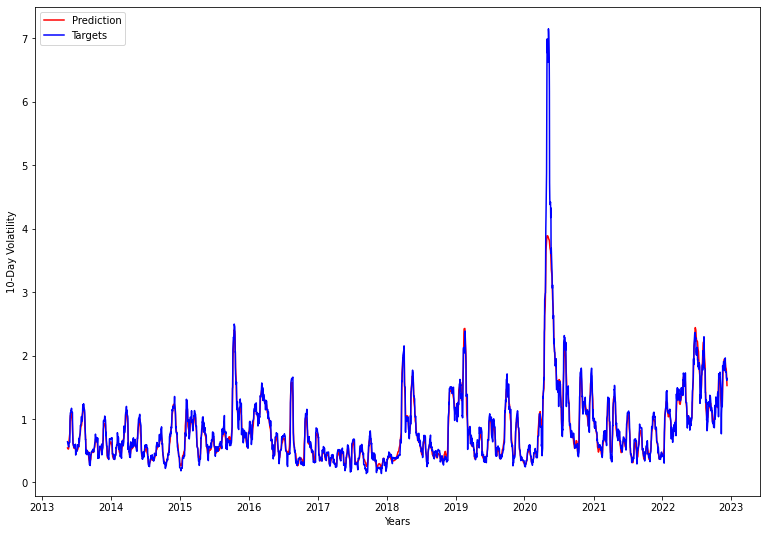

In [107]:
df = data.copy()
df = df.tail(len(preds))
df.drop(df.columns, inplace=True, axis=1)
df['preds'] = preds

# Generate output
plt.figure(figsize=(13,9))
plt.plot(df.index, preds, label="Prediction", color="red")
plt.plot(df.index, targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

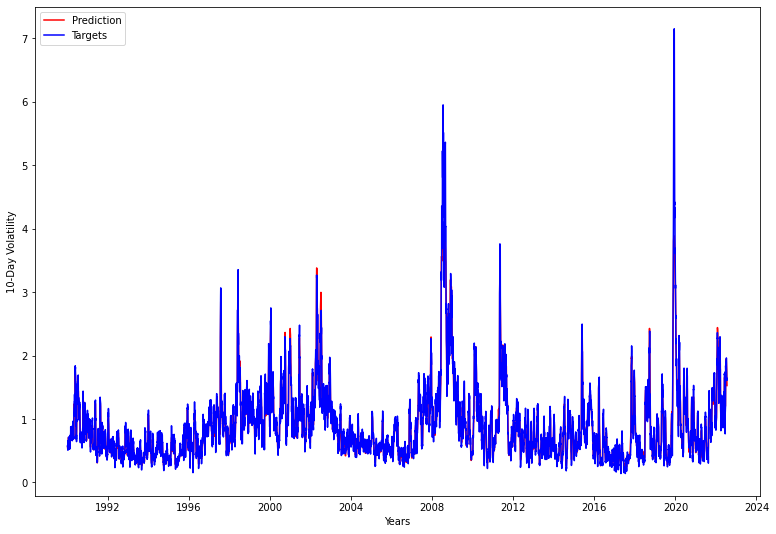

Test loss : 0.02839169


In [108]:
# Prediction for the entire dataset
data_loader = DataLoaderForVolatilityModeling(dataset, vol_10,batch_size=1, sequence_length=config['look_back'], shuffle=False)

# Make predictions
preds, targets, test_loss = predict(data_loader, model)

# Generate output
plt.figure(figsize=(13,9))
plt.plot(data.index[:len(preds)], preds, label="Prediction", color="red")
plt.plot(data.index[:len(targets)], targets, label="Targets", color="blue")
plt.xlabel("Years")
plt.ylabel("10-Day Volatility")
plt.legend(loc="upper left")
plt.show()

loss = 'Test loss : {:.07}'.format(test_loss)
print(loss)